In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.graphics.tsaplots

In [2]:
sns.set(style='whitegrid', palette="Set2", color_codes=True)
%matplotlib inline

In [3]:
Project_Dir = os.getcwd()
Processed_Data_Dir = Project_Dir + r"/Processed_Data"

In [4]:
DATA_UNDLY=pd.read_csv(Processed_Data_Dir+'/Underlyings.csv',usecols=np.arange(1,6),parse_dates=['Date'])

In [5]:
DATA_UNDLY.shape

(4938, 5)

In [6]:
DATA_UNDLY.head()

,Date,Close,Fig,Ten_ma,pct_chg
0,2015-08-20,287.5,GASL,355.7,-0.066558
1,2015-08-21,261.5,GASL,350.3,-0.090435
2,2015-08-24,216.0,GASL,332.7,-0.173996
3,2015-08-25,205.5,GASL,316.1,-0.048611
4,2015-08-26,227.0,GASL,296.7,0.104623


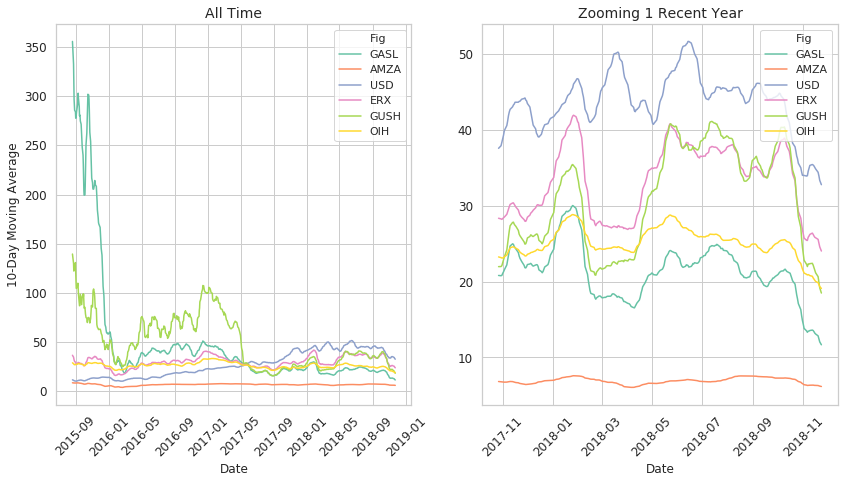

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(data=DATA_UNDLY,hue='Fig',y='Ten_ma',x='Date',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(ylabel='10-Day Moving Average',title='All Time')

sns.lineplot(data=DATA_UNDLY[DATA_UNDLY.Date>"2017-10-26"],hue='Fig',y='Ten_ma',x='Date',ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(ylabel='',title='Zooming 1 Recent Year')
for ax in ax:
    for item in ([ax.yaxis.label,ax.xaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
#     ax.set(title='Suggested Weight Adjustment For KAM\'s Features\n')
    # ax.xaxis.label.set_fontsize(13)
    ax.title.set_fontsize(14)
# plt.show()

In [8]:
dt_undly=DATA_UNDLY

* Get Rid of underlyings with low volatility

# Test GBM's Assumption 

* Correlation

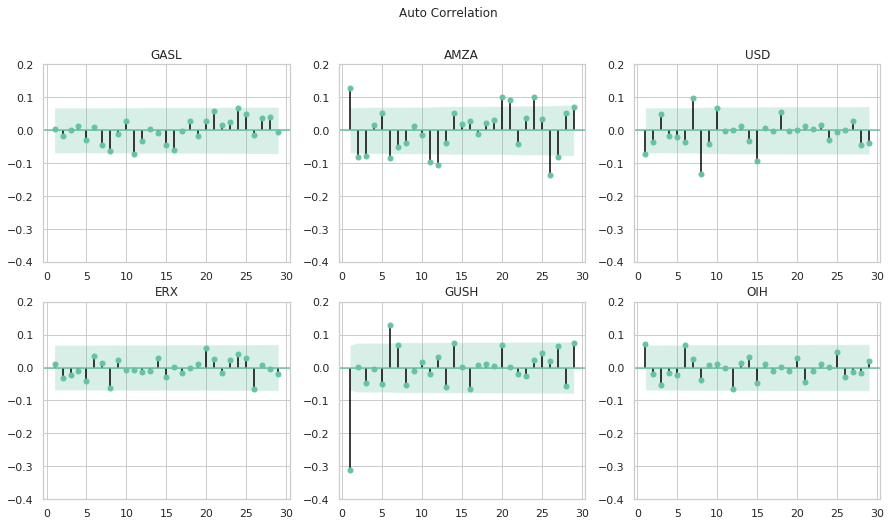

In [9]:
nrow,ncol,ax_ind=2, 3,0
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Auto Correlation')
gs1 = gridspec.GridSpec(nrow,ncol)
ax_ls = [fig.add_subplot(ss) for ss in gs1]
for fig in dt_undly.Fig.unique():
    ax=ax_ls[ax_ind]
    statsmodels.graphics.tsaplots.plot_acf(x=dt_undly[dt_undly.Fig==fig].pct_chg,unbiased=False, lags=np.arange(1,30)
                                           ,alpha=0.05,ax=ax)
    ax.set(title=fig,ylim=(-0.4,0.2))
    ax_ind+=1

* Choose growth window for each underlyinng

Eyball: Choose 2 day as project lap.

In [10]:
g_window=dict(zip(dt_undly.Fig.unique().tolist(),[1,4,4,1,2,3]))
g_window

{'GASL': 1, 'AMZA': 4, 'USD': 4, 'ERX': 1, 'GUSH': 2, 'OIH': 3}

#  Jarque-Bera Test

In [11]:
from scipy.stats import jarque_bera

In [12]:
data_close_pvt=dt_undly[['Date','Close','Fig']].pivot(index='Date',columns='Fig')
data_close_pvt.columns=data_close_pvt.columns.droplevel(0)

In [13]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,8.46,32.13,287.5,139.21,27.15,10.58
2015-08-21,8.22,28.83,261.5,125.06,26.26,9.99
2015-08-24,7.92,24.18,216.0,106.41,24.90,9.75
2015-08-25,7.88,23.03,205.5,98.23,24.90,9.37
2015-08-26,8.49,25.43,227.0,104.81,25.84,10.13


In [14]:
jb_result=[]
for col in data_close_pvt.columns:
    window=g_window[col]
    gamma=data_close_pvt[col].pct_change(window)
    jb_result.append(
        [col,window]+
        list(
            jarque_bera(gamma.dropna().values)
        )
    )
pd.DataFrame(jb_result,columns=['Fig','Window','JB_Val','P_Val'])

,Fig,Window,JB_Val,P_Val
0,AMZA,4,1865.309149,0.000000
1,ERX,1,76.445066,0.000000
2,GASL,1,782.893855,0.000000
3,GUSH,2,3024.206357,0.000000
4,OIH,3,102.606641,0.000000
5,USD,4,22.862180,0.000011


# Generate Underlying Price 

* Sample Path Span

In [15]:
DATA_OPT=pd.read_csv(Processed_Data_Dir+'/Options.csv',index_col=[0],parse_dates=['Maturity','D2M'])

DATA_OPT.D2M=pd.to_timedelta(DATA_OPT.D2M)

In [16]:
DATA_OPT.head()

,Maturity,Fig,Strike,Ask_p,D2M
0,2018-12-21,GASL,1.0,0.55,28 days
1,2018-12-21,GASL,2.0,0.55,28 days
2,2018-12-21,GASL,3.0,0.55,28 days
3,2018-12-21,GASL,4.0,0.55,28 days
4,2018-12-21,GASL,5.0,0.75,28 days


In [17]:
DATA_OPT.groupby(['D2M','Fig'],group_keys=False).agg({'Fig':'count'})

Fig
D2M      Fig      
14 days  ERX    16
         OIH    11
21 days  ERX    16
         OIH    12
25 days  GUSH    1
28 days  AMZA    6
         ERX    16
         GASL    9
         GUSH    6
         OIH    13
         USD    10
35 days  ERX    15
         OIH    11
42 days  ERX    17
         OIH    10
49 days  ERX    16
         OIH    10
56 days  AMZA    6
         ERX     4
         GASL    8
         GUSH    8
         OIH     9
         USD    15
84 days  ERX    11
         GASL    8
         GUSH    7
         USD    12
112 days AMZA    6
         GASL    7
         GUSH    3
146 days ERX     7
         OIH    10
175 days USD     7
210 days GUSH    3
420 days GUSH    3
784 days GUSH    3

In [18]:
Gen_Span=pd.Timedelta(56,'D')

In [19]:
dt_option=DATA_OPT[DATA_OPT.D2M<=Gen_Span]

In [20]:
dt_option.shape,dt_option.columns

((245, 5),
 Index(['Maturity', 'Fig', 'Strike', 'Ask_p', 'D2M'], dtype='object'))

* Mean, Std, Corr

In [33]:
dt_gamma=pd.DataFrame([])
for col in data_close_pvt.columns:
    window=g_window[col]
    dt_gamma[col]=data_close_pvt[col].pct_change(window)

In [34]:
dt_gamma.mean()

AMZA   -0.000228
ERX     0.000339
GASL   -0.001355
GUSH    0.026784
OIH    -0.000638
USD     0.007054
dtype: float64

In [27]:
dt_gamma.head()

,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-21,NaN,-0.102775,-0.090435,NaN,NaN,NaN
2015-08-24,NaN,-0.161115,-0.173996,-0.235652,NaN,NaN
2015-08-25,NaN,-0.047812,-0.048611,-0.214581,-0.082730,NaN
2015-08-26,0.0031,0.104255,0.104623,-0.015018,-0.016037,-0.042452


In [40]:
dt_gamma[dt_gamma.index>pd.to_datetime('2017-9-1')].mean()

AMZA   -0.001473
ERX     0.000431
GASL   -0.000591
GUSH    0.002408
OIH    -0.000996
USD     0.002491
dtype: float64

In [41]:
nTrial=10000
Start_Date=pd.to_datetime('2017-9-1')
Gen_Mean,Gen_Cov=dt_gamma[dt_gamma.index>Start_Date].mean(),dt_gamma[dt_gamma.index>Start_Date].cov()


In [42]:
sim_gamma=np.random.multivariate_normal(mean=Gen_Mean,cov=Gen_Cov,size=(nTrial,Gen_Span.days+10))

In [43]:
sim_gamma.shape

(10000, 66, 6)

In [44]:
sim_gamma=dict(zip(dt_gamma.columns.tolist(),[sim_gamma[:,:,fig] for fig in range(sim_gamma.shape[2])]))

In [45]:
sim_gamma['GUSH'].shape

(10000, 66)

In [49]:
sim_gamma

{'AMZA': array([[ 0.03293357, -0.01545913, -0.04084956, ...,  0.03677481,
          0.04142482,  0.015456  ],
        [ 0.03573499,  0.02879   , -0.03543067, ...,  0.02633808,
         -0.02583536, -0.00152756],
        [-0.04056261,  0.00118306,  0.03272551, ..., -0.01315384,
          0.05691055,  0.00849967],
        ...,
        [ 0.00510498, -0.01640217,  0.03029408, ..., -0.04085177,
          0.02359268,  0.03057949],
        [ 0.00224101, -0.04528403, -0.01122355, ...,  0.0159778 ,
          0.02767281,  0.02291383],
        [ 0.01039508,  0.01899357,  0.02456366, ...,  0.00459546,
         -0.00487251,  0.03639895]]),
 'ERX': array([[ 4.96145126e-02,  9.39653889e-03, -7.16832878e-02, ...,
         -2.87691572e-02,  6.79728564e-02,  6.60832595e-02],
        [ 5.49326689e-02,  8.11152155e-03, -1.70322349e-02, ...,
          7.51714520e-03, -2.79119187e-02, -4.27570272e-02],
        [-7.15775671e-02, -1.14648480e-03,  5.51233625e-02, ...,
         -6.12081356e-03,  4.46525669e-02

In [46]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,8.46,32.13,287.5,139.21,27.15,10.58
2015-08-21,8.22,28.83,261.5,125.06,26.26,9.99
2015-08-24,7.92,24.18,216.0,106.41,24.90,9.75
2015-08-25,7.88,23.03,205.5,98.23,24.90,9.37
2015-08-26,8.49,25.43,227.0,104.81,25.84,10.13


In [165]:
sim_undly={}
sim_g_rshp={}
for key,val in sim_gamma.items():
    print(key,val.shape)
    window=g_window[key]
    less=val.shape[1]%window
    if window!=1:                
        new_sim=val[:,:-less] if less!=0 else val
        sim_g_rshp[key]=new_sim.reshape(nTrial,new_sim.shape[1]//window,window)
    else:
        sim_g_rshp[key]=val
    print('\t',window,less,sim_g_rshp[key].shape)    
    s0=data_close_pvt[key][-window:].values
    cum_g=(sim_g_rshp[key]+1).cumprod(axis=1)
    print('\t',s0.shape,cum_g.shape)
    sim_undly[key]=(s0*cum_g).reshape(nTrial,-1)[:,:Gen_Span.days]   
    print('\t',sim_undly[key].shape)

AMZA (10000, 66)
	 4 2 (10000, 16, 4)
	 (4,) (10000, 16, 4)
	 (10000, 56)
ERX (10000, 66)
	 1 0 (10000, 66)
	 (1,) (10000, 66)
	 (10000, 56)
GASL (10000, 66)
	 1 0 (10000, 66)
	 (1,) (10000, 66)
	 (10000, 56)
GUSH (10000, 66)
	 2 0 (10000, 33, 2)
	 (2,) (10000, 33, 2)
	 (10000, 56)
OIH (10000, 66)
	 3 0 (10000, 22, 3)
	 (3,) (10000, 22, 3)
	 (10000, 56)
USD (10000, 66)
	 4 2 (10000, 16, 4)
	 (4,) (10000, 16, 4)
	 (10000, 56)


In [155]:
b=np.random.normal(0.002,0.01,66)

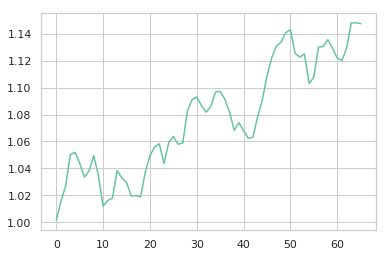

In [156]:
plt.plot((b+1).cumprod(axis=0))

In [136]:
a=np.arange(66)
a=np.array([a,a,a])
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65]])

In [159]:
(a.reshape(3,33,2)+1).shape

(3, 33, 2)

In [160]:
((a.reshape(3,33,2)+1).cumprod(axis=1))

array([[[                   1,                    2],
        [                   3,                    8],
        [                  15,                   48],
        [                 105,                  384],
        [                 945,                 3840],
        [               10395,                46080],
        [              135135,               645120],
        [             2027025,             10321920],
        [            34459425,            185794560],
        [           654729075,           3715891200],
        [         13749310575,          81749606400],
        [        316234143225,        1961990553600],
        [       7905853580625,       51011754393600],
        [     213458046676875,     1428329123020800],
        [    6190283353629375,    42849873690624000],
        [  191898783962510625,  1371195958099968000],
        [ 6332659870762850625, -8719569645729742848],
        [  282166592185152483,  -309857993208365056],
        [-800658016285890974

In [54]:
(sim_g_rshp['USD']+1).cumprod(axis=0).shape

(10000, 16, 4)

In [58]:
(sim_g_rshp['USD']+1).cumprod(axis=0).round(2)[1]*data_close_pvt['USD'][-4:].values

array([[33.6744    , 34.4299989 , 28.71319908, 28.85790093],
       [30.2446    , 31.299999  , 30.27369903, 31.030001  ],
       [33.6744    , 30.98699901, 30.89789901, 32.58150105],
       [30.2446    , 28.48299909, 32.45839896, 28.85790093],
       [35.2334    , 31.61299899, 26.52849915, 27.61670089],
       [29.621     , 33.49099893, 27.77689911, 30.71970099],
       [30.5564    , 30.04799904, 26.21639916, 29.16820094],
       [34.6098    , 29.73499905, 36.51569883, 34.75360112],
       [30.5564    , 35.99499885, 30.89789901, 29.47850095],
       [28.3738    , 33.80399892, 33.08259894, 28.23730091],
       [30.8682    , 33.49099893, 31.209999  , 28.54760092],
       [33.6744    , 32.23899897, 29.02529907, 32.58150105],
       [36.1688    , 25.35299919, 32.14629897, 29.16820094],
       [29.3092    , 32.23899897, 30.27369903, 26.06520084],
       [36.4806    , 31.299999  , 30.89789901, 29.78880096],
       [32.4272    , 35.36899887, 27.77689911, 28.85790093]])

In [59]:
data_close_pvt['USD'][-4:].values

array([31.18    , 31.299999, 31.209999, 31.030001])

In [60]:
sim_undly['USD'].shape

(10000, 56)

In [63]:
sim_undly['USD'][:,1].round(2).tolist()

[32.35,
 34.29,
 36.84,
 32.87,
 32.17,
 31.92,
 28.21,
 29.17,
 29.85,
 28.56,
 27.14,
 24.63,
 26.71,
 26.21,
 28.04,
 31.64,
 34.11,
 37.8,
 38.91,
 40.43,
 39.74,
 43.9,
 44.37,
 41.96,
 45.03,
 41.64,
 44.71,
 42.48,
 42.32,
 44.44,
 44.37,
 43.6,
 46.18,
 47.91,
 48.73,
 49.8,
 50.22,
 53.2,
 52.61,
 48.37,
 48.21,
 45.76,
 45.3,
 44.68,
 44.88,
 43.36,
 46.22,
 50.05,
 44.03,
 38.62,
 32.21,
 35.23,
 33.91,
 36.28,
 37.53,
 37.17,
 39.64,
 40.0,
 40.22,
 41.1,
 41.79,
 41.57,
 45.31,
 45.49,
 50.71,
 49.01,
 50.19,
 44.51,
 44.18,
 47.28,
 49.69,
 44.13,
 43.49,
 43.5,
 43.25,
 42.66,
 44.05,
 45.35,
 45.12,
 45.32,
 43.91,
 47.66,
 52.83,
 49.84,
 45.5,
 47.8,
 45.71,
 48.5,
 48.4,
 49.53,
 50.92,
 52.04,
 51.76,
 54.45,
 53.84,
 51.46,
 50.46,
 51.61,
 47.3,
 47.65,
 51.3,
 53.24,
 48.76,
 49.74,
 49.75,
 56.01,
 53.96,
 54.86,
 53.65,
 61.25,
 61.85,
 64.02,
 69.09,
 68.51,
 72.99,
 74.2,
 78.44,
 71.28,
 67.95,
 68.7,
 72.58,
 71.48,
 76.25,
 79.85,
 71.28,
 63.38,
 63.25,
 

In [166]:
def sim_result(sim_undly,k):
    sim_undly0={}
    for key,val in sim_undly.items():
        sim_undly0[key]=val[k]
    sim_undly0=pd.DataFrame(sim_undly0)
    sim_undly0_longform=sim_undly0.reset_index().melt(id_vars=['index'],var_name='fig',value_name='close')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax=sns.lineplot(data=sim_undly0_longform,hue='fig',y='close',x='index')
    return ax

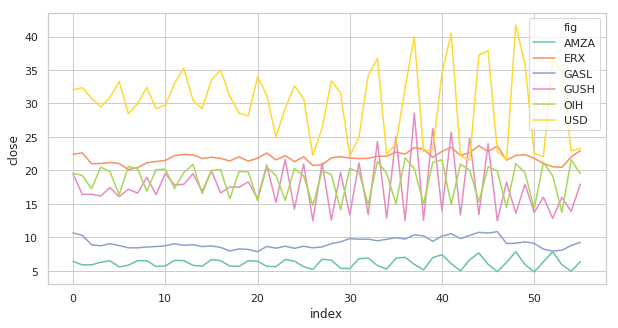

In [168]:
sim_result(sim_undly,0)

In [169]:
class sim_result:
    def __init__(self, sim_undly):
        self.underlying=sim_undly
        self.max=sim_undly[list(sim_undly.keys())[0]].shape[0]
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n <= self.max:
#             plt.close()
            sim_undly0={}
            for key,val in self.underlying.items():
                sim_undly0[key]=val[self.n]
            sim_undly0=pd.DataFrame(sim_undly0)
            sim_undly0_longform=sim_undly0.reset_index().melt(id_vars=['index'],var_name='fig',value_name='close')
#             fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            sns.lineplot(data=sim_undly0_longform,hue='fig',y='close',x='index')
            self.n += 1
            print(self.n)
#             plt.close(fig)
#             return sns.lineplot(data=sim_undly0_longform,hue='fig',y='close',x='index')
        else:
            raise StopIteration

In [170]:
sim_iter=iter(sim_result(sim_undly))

9


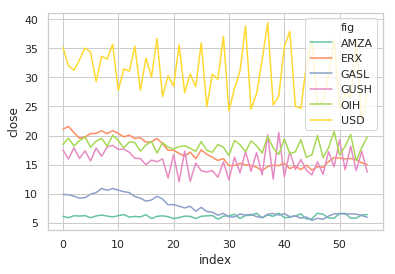

In [179]:
next(sim_iter)


In [518]:
plt.close()

'ERX'

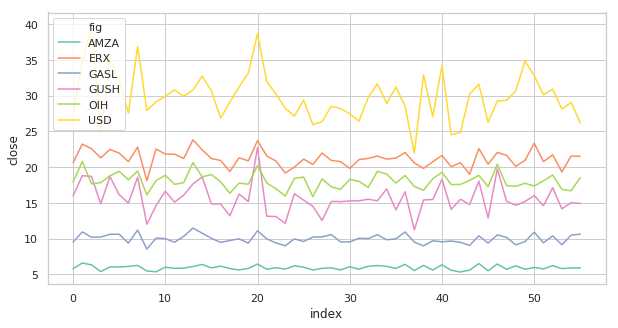

In [347]:
sim_result(sim_undly,1)

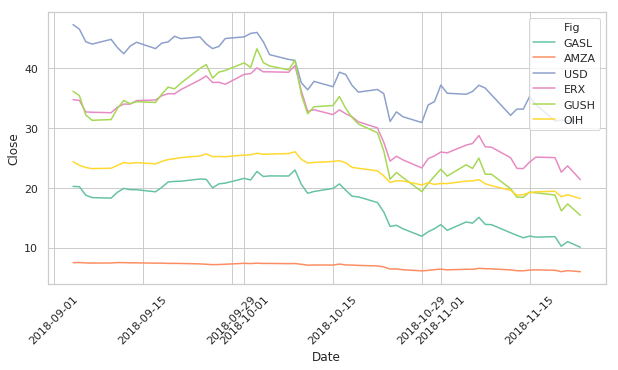

In [323]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=DATA_UNDLY[DATA_UNDLY.Date>Start_Date],hue='Fig',y='Close',x='Date',ax=ax)
ax.tick_params(axis='x', rotation=45)

In [216]:
(sim_gamma['GUSH'][0]+1).cumprod(axis=0)*data_close_pvt['GUSH'][-2:].values

array([[  9.57583496,  20.99338419],
       [ 12.76831768,  23.34200173],
       [ 16.68317086,  25.01545603],
       [ 26.99245885,  14.4166129 ],
       [ 22.9395085 ,  12.25715942],
       [ 15.21675079,  14.74081665],
       [ 23.42920437,  17.40531335],
       [  5.04122379,  26.84025619],
       [  6.6922675 ,  42.17863331],
       [  4.36316283,  55.93957117],
       [  2.55466073,  67.91132516],
       [  3.29015627,  58.37712789],
       [  2.35054288,  66.65957518],
       [  1.59878044,  53.43231671],
       [  1.89159675,  53.98187358],
       [  2.06489753,  70.53233468],
       [  1.53659732,  83.96806201],
       [  1.23403454, 131.47289131],
       [  1.89733004,  87.64639376],
       [  2.69928796, 100.42447601],
       [  3.14934611, 122.99300032],
       [  2.37132867, 138.35738885],
       [  3.00557169, 169.81145828],
       [  2.4313947 , 216.78934141],
       [  3.00233297, 153.67723879],
       [  3.88008858, 186.05379751],
       [  4.06700305, 117.75699726],
 

In [217]:
((sim_gamma['GUSH'][0]+1).cumprod(axis=0)*data_close_pvt['GUSH'][-2:].values).flatten()

array([  9.57583496,  20.99338419,  12.76831768,  23.34200173,
        16.68317086,  25.01545603,  26.99245885,  14.4166129 ,
        22.9395085 ,  12.25715942,  15.21675079,  14.74081665,
        23.42920437,  17.40531335,   5.04122379,  26.84025619,
         6.6922675 ,  42.17863331,   4.36316283,  55.93957117,
         2.55466073,  67.91132516,   3.29015627,  58.37712789,
         2.35054288,  66.65957518,   1.59878044,  53.43231671,
         1.89159675,  53.98187358,   2.06489753,  70.53233468,
         1.53659732,  83.96806201,   1.23403454, 131.47289131,
         1.89733004,  87.64639376,   2.69928796, 100.42447601,
         3.14934611, 122.99300032,   2.37132867, 138.35738885,
         3.00557169, 169.81145828,   2.4313947 , 216.78934141,
         3.00233297, 153.67723879,   3.88008858, 186.05379751,
         4.06700305, 117.75699726,   2.88135554, 111.40989827,
         3.66396438, 102.66264478,   5.3484505 , 106.36329146,
         7.93749269, 137.85907872,  11.26162247, 221.63

In [144]:
a


{'1': 2}

In [205]:
a=np.arange(1,13)
a

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [208]:
a.cumprod()

array([        1,         2,         6,        24,       120,       720,
            5040,     40320,    362880,   3628800,  39916800, 479001600])

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [120]:
a.reshape(3,4).reshape(3,2,2)

array([[[ 1,  2],
        [ 3,  4]],

       [[ 5,  6],
        [ 7,  8]],

       [[ 9, 10],
        [11, 12]]])

In [41]:
mean_std=[]
for col in data_close_pvt.columns:
    window=g_window[col]
    gamma=data_close_pvt[col].pct_change(window)
    mean_std.append(
        [col,window]+[gamma.mean(),gamma.std()]+\
        []
    )
pd.DataFrame(mean_std,columns=['Fig','Window','Mean','std'])

AssertionError: 4 columns passed, passed data had 5 columns

In [38]:
data_close_pvt['AMZA'].pct_change(4)

Date
2015-08-20         NaN
2015-08-21         NaN
2015-08-24         NaN
2015-08-25         NaN
2015-08-26    0.003100
2015-08-27    0.097001
2015-08-28    0.139073
2015-08-31    0.141172
2015-09-01    0.008653
2015-09-02   -0.047702
2015-09-03   -0.034302
2015-09-04   -0.035554
2015-09-08    0.012132
2015-09-09   -0.010996
2015-09-10   -0.023480
2015-09-11   -0.067191
2015-09-14   -0.076159
2015-09-15   -0.057443
2015-09-16   -0.047472
2015-09-17    0.023037
2015-09-18   -0.002621
2015-09-21    0.026868
2015-09-22   -0.012298
2015-09-23   -0.082778
2015-09-24   -0.057162
2015-09-25   -0.090619
2015-09-28   -0.141546
2015-09-29   -0.170125
2015-09-30   -0.069686
2015-10-01   -0.014035
                ...   
2018-10-12   -0.030464
2018-10-15   -0.034346
2018-10-16    0.005376
2018-10-17    0.005487
2018-10-18   -0.002732
2018-10-19   -0.008208
2018-10-22   -0.042966
2018-10-23   -0.046931
2018-10-24   -0.093089
2018-10-25   -0.082633
2018-10-26   -0.092199
2018-10-29   -0.097384
2018-1

In [27]:
data_close_pvt.columns

Index(['AMZA', 'ERX', 'GASL', 'GUSH', 'OIH', 'USD'], dtype='object', name='Fig')

In [97]:
data_close_pvt.describe()

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,6.915711,30.135692,48.171397,49.169707,26.385358,27.733600
std,0.855429,5.751987,61.706407,27.631722,2.909993,12.854218
min,3.684273,14.178413,10.050000,13.582627,18.190001,9.371198
25%,6.657159,26.431273,21.064999,25.569237,24.394999,14.582064
50%,7.106954,29.688633,28.299999,38.951221,26.199986,25.464329
75%,7.453390,34.414484,42.555000,68.841793,28.218953,41.233307
max,9.024482,43.237911,363.700012,151.335861,34.037975,53.058846


In [151]:
dt_gamma2=data_close_pvt.pct_change(2)

In [152]:
dt_gamma2.head()

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-21,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-24,-0.063856,-0.247332,-0.248696,-0.235652,-0.082730,-0.078927
2015-08-25,-0.042119,-0.201224,-0.214149,-0.214581,-0.051675,-0.062317
2015-08-26,0.071523,0.051459,0.050926,-0.015018,0.037580,0.039601


,Fig,JB_Val,P_Val
0,AMZA,3984.514708,0.0
1,ERX,170.462347,0.0
2,GASL,1343.924841,0.0
3,GUSH,3024.206357,0.0
4,OIH,84.478748,0.0
5,USD,94.533859,0.0


In [116]:
dt_gamma2['AMZA'].dropna().values

array([-6.38559862e-02, -4.21185438e-02,  7.15231014e-02,  1.45236530e-01,
        6.30406947e-02, -3.54874808e-03, -5.11628257e-02, -4.43107609e-02,
        1.77696127e-02,  9.16288382e-03, -5.53889129e-03, -1.99756591e-02,
       -1.80407655e-02, -4.81777976e-02, -5.91863010e-02, -9.73407689e-03,
        1.24512215e-02,  3.30930567e-02, -1.48869471e-02, -6.02594406e-03,
        2.62797444e-03, -7.72176343e-02, -5.96328980e-02, -1.45228705e-02,
       -8.71080084e-02, -1.57894723e-01,  1.90839972e-02,  1.70833446e-01,
        1.01872548e-01,  1.09608542e-01,  3.97867021e-02,  6.96512815e-03,
        5.07099844e-02,  6.91695070e-03, -3.60359196e-02, -4.08898567e-02,
       -1.46862738e-02,  1.90995940e-02,  2.57452119e-02, -1.27172085e-02,
       -1.91546750e-02, -1.42375669e-02, -5.31985581e-02, -4.26409682e-02,
       -4.48081965e-02, -6.75288271e-02,  2.30827795e-02,  9.24500422e-02,
        4.80348935e-02,  2.96192494e-02,  5.34723920e-02,  0.00000000e+00,
       -6.32827443e-02, -

In [105]:
dt_gamma2.columns

Index(['AMZA', 'ERX', 'GASL', 'GUSH', 'OIH', 'USD'], dtype='object', name='Fig')

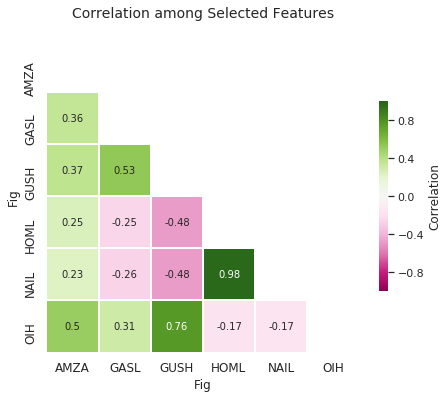

In [10]:
corr=data_close_pvt.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(7, 7))
with sns.axes_style(style='white'):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1,
                     square=True,
#                      xticklabels=labs_heatmap_x,
#                      yticklabels=labs_heatmap_y,
                     center=0,
                     annot=True,
                     # ax=ax,
                     cmap="PiYG",
                     linewidths=.5,
                     cbar_kws={"shrink": .5,
                               'label': 'Correlation'
                               }
                     )
for item in ([ax.yaxis.label,ax.xaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.set(title='Correlation among Selected Features\n')
ax.title.set_fontsize(14)
plt.show()


In [11]:
data_chg_pvt=data[['Date','pct_chg','Fig']].pivot(index='Date',columns='Fig')
data_chg_pvt.columns=data_chg_pvt.columns.droplevel(0)

In [12]:
data_chg_pvt.head().round(3)

Fig,AMZA,GASL,GUSH,HOML,NAIL,OIH
Date,,,,,,
2015-08-20,-0.036,-0.067,-0.081,-0.044,-0.052,-0.028
2015-08-21,-0.029,-0.090,-0.102,-0.032,-0.055,-0.033
2015-08-24,-0.036,-0.174,-0.149,-0.115,0.000,-0.052
2015-08-25,-0.006,-0.049,-0.077,-0.064,-0.071,0.000
2015-08-26,0.078,0.105,0.067,0.060,-0.156,0.038


In [13]:
data_chg_pvt.describe()[1:3]

Fig,AMZA,GASL,GUSH,HOML,NAIL,OIH
mean,-0.000189,-0.001434,0.022781,0.000217,0.000495,-0.000328
std,0.023730,0.073394,0.252690,0.030317,0.041396,0.019669


In [14]:
data_close_pvt.cov()

Fig,AMZA,GASL,GUSH,HOML,NAIL,OIH
Fig,,,,,,
AMZA,0.731759,18.913427,8.721908,2.811449,3.919790,1.249996
GASL,18.913427,3807.680681,909.575396,-195.874916,-240.748777,55.520895
GUSH,8.721908,909.575396,763.512061,-172.854218,-267.229358,60.977748
HOML,2.811449,-195.874916,-172.854218,167.452579,254.453819,-6.503737
NAIL,3.919790,-240.748777,-267.229358,254.453819,397.097861,-9.786324
OIH,1.249996,55.520895,60.977748,-6.503737,-9.786324,8.468061


In [15]:
def sim_NTL(mu,cov,NTR):
    result=[]
    for n in range(NTR):    
        z_sim=np.column_stack([np.random.multivariate_normal(1+mu,cov,24),[1.0085]*24])    
        result.append(np.append(z_sim.prod(0),
                                [z_sim.prod(0).mean(),z_sim.mean(1).prod()])*100)
    return result

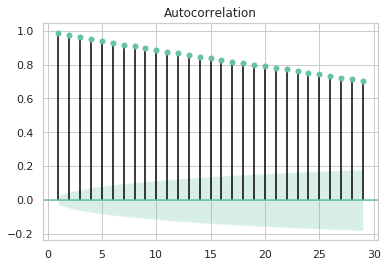

In [24]:
ax=statsmodels.graphics.tsaplots.plot_acf(x=data.Ten_ma, lags=np.arange(1,30),alpha=0.05)

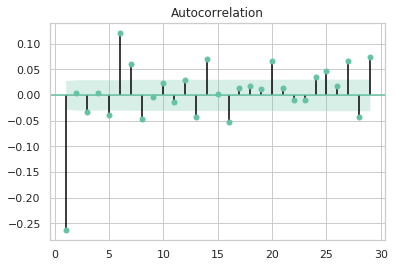

In [17]:
ax=statsmodels.graphics.tsaplots.plot_acf(x=data.pct_chg,unbiased=False, lags=np.arange(1,30),alpha=0.05)

ax=statsmodels.graphics.tsaplots.plot_pacf(x=data.pct_chg, lags=np.arange(1,30),alpha=0.05)